# Importing required packages:

In [1]:
import pandas as pd
import numpy as np

from sagemaker_sklearn_extension.feature_extraction.text import MultiColumnTfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import datetime
from dateutil.parser import parse

# from category_encoders.basen import BaseNEncoder

from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
from matplotlib import pyplot as plt 
sns.set(style="darkgrid")

pd.options.display.max_colwidth=500
pd.options.display.max_columns=300
# pd.options.plotting.backend = "plotly"

# Loading data and defining target column:

In [2]:
data = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv')
# data = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Pred_Main_Reg.csv')

In [3]:
target = 'loss'

y = data[target]
data.drop(target, axis = 1, inplace = True)

# Exploratory data analysis:

In [4]:
def parse_dates(x):
    try:
        return parse(x,fuzzy=True)
    except:
        return ''

def define_type(tmp, report):
    """
    Function with logic for defining type of column with availible options:
    The main idea is based on https://datascience.stackexchange.com/questions/9892/how-can-i-dynamically-distinguish-between-categorical-data-and-numerical-data
    and my own assumptions an observations
        - 'missing'
        - 'datetime'
        - 'text'
        - 'binary'
        - 'categorical'
        - 'numeric'
    """
    if report['rate of NaN']>0.98:
        return 'missing', 0
    
    ## defining if the column is of type datetime:
    s = 0
    for el in tmp:
        if isinstance(parse_dates(el),datetime.datetime):
            s+=1
    if s>0.999*report['number of not NaN'] and report['number of unique lenght']<=2 and report['rate of unique']>0.01:
        return 'datetime', s
    ####
    
    if (tmp.dtype.char == 'O' or tmp.dtype.char == 'S') and report['rate of unique']>0.7:
        return 'text',0
    
    if report['number of unique']<=2:
        return 'binary',0
    
    score = 0
    if (tmp.dtype.char == 'i' or tmp.dtype.char == 'f' or tmp.dtype.char == 'd' or tmp.dtype.char == 'l'):
        score+=0.8
        score+=report['rate of unique']*10
    if report['isNormalDistribution']==1:
        score+=0.1
    if score<1:
        return 'categorical',score
    else:
        return 'numeric',score

def get_info(tmp):
    ## Total number
    total_number = len(tmp)

    ## Number of NaN
    number_of_na = tmp.isna().sum()
    rate_of_na = number_of_na/total_number

    ## Number of not NaN
    tmp = tmp.dropna()
    number_of_not_na = tmp.count()

    ## Number of unique
    number_of_unique = len(tmp.unique())

    rate_of_unique = number_of_unique/number_of_not_na

    number_of_unique_len = len(tmp.astype(str).apply(len).unique())

    try:
        ## is normally distributed:
        alpha = 0.05
        k2, p = scipy.stats.normaltest(tmp)
        if p < alpha:  # null hypothesis: x comes from a normal distribution
            normal = 0
        else:
            normal = 1
    except:
        normal = 0

    report = {'column':col,
              'number of records': total_number,
              'number of NaN': number_of_na,
              'rate of NaN':rate_of_na,
              'number of not NaN': number_of_not_na,
             'number of unique': number_of_unique,
             'rate of unique': rate_of_unique,
             'number of unique lenght': number_of_unique_len,
             'isNormalDistribution':normal}
    
    report['estimated type'], report['score'] = define_type(tmp, report)
    return report


In [5]:
# Making report out of provided data
final_report = []
for col in data.columns:
    tmp = data[col]
    report = get_info(tmp)
    final_report.append(report)
 
eda = pd.DataFrame(final_report)
eda

/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ISO identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname SOV identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/trokhymovych/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname UL identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,column,number of records,number of NaN,rate of NaN,number of not NaN,number of unique,rate of unique,number of unique lenght,isNormalDistribution,estimated type,score
0,Exposure,1217,1007,0.827445,210,5,0.023810,1,0,numeric,1.038095
1,Rating_Class,1217,87,0.071487,1130,38,0.033628,1,0,categorical,0.000000
2,Sub_Rating_Class,1217,1212,0.995892,5,3,0.600000,1,0,missing,0.000000
3,Renewal_class,1217,1093,0.898110,124,6,0.048387,1,0,categorical,0.000000
4,Sub_Renewal_Class,1217,1114,0.915366,103,3,0.029126,1,0,categorical,0.000000
5,Property_size,1217,1,0.000822,1216,8,0.006579,1,0,categorical,0.865789
6,Residents,1217,5,0.004108,1212,6,0.004950,1,0,categorical,0.849505
7,Commercial,1217,219,0.179951,998,2,0.002004,1,0,binary,0.000000
8,Norm_fire_risk,1217,0,0.000000,1217,14,0.011504,3,0,categorical,0.915037
9,Norm_monthly_rent,1217,0,0.000000,1217,1041,0.855382,8,0,numeric,9.353821


## Making some basic plots using pandas and plotly backend for plotting:
*important: Please, rerun notebook in order to see the plots

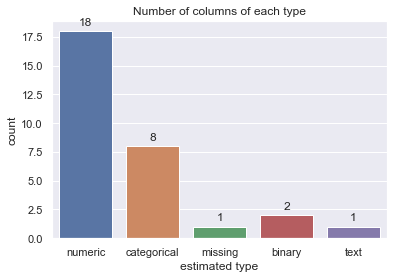

In [6]:
ax = sns.countplot(x="estimated type", data=eda)
total = float(len(eda))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width() /2.,
            height+ 0.5,
            '{:1.0f}'.format(height),
            ha="center") 
plt.title('Number of columns of each type')
plt.show()

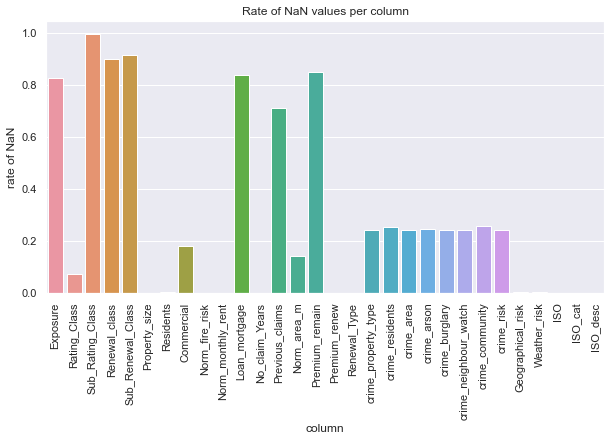

In [7]:
plt.figure(figsize=(10,5))
ax = sns.barplot(y="rate of NaN", x='column', data=eda)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Rate of NaN values per column')
plt.show()

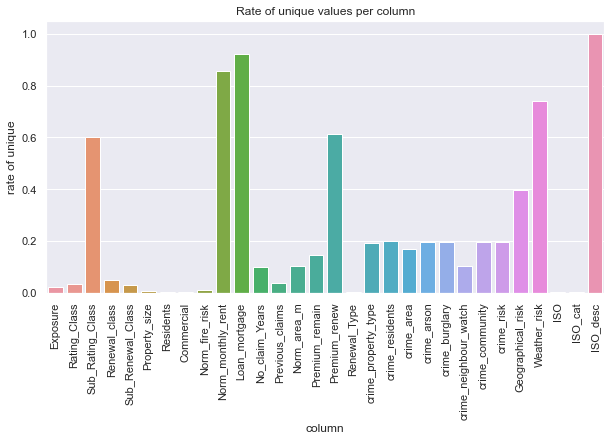

In [8]:
plt.figure(figsize=(10,5))
ax = sns.barplot(y="rate of unique", x='column', data=eda)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Rate of unique values per column')
plt.show()

# Feature enginering

In [9]:
binary_columns = eda[eda['estimated type'] == 'binary'].column.values
missing_columns = eda[eda['estimated type'] == 'missing'].column.values
text_columns = eda[eda['estimated type'] == 'text'].column.values
numeric_columns = eda[eda['estimated type'] == 'numeric'].column.values
cat_columns1 = eda[(eda['estimated type'] == 'categorical')&(eda['number of unique'] < 10)].column.values
cat_columns2 = eda[(eda['estimated type'] == 'categorical')&(eda['number of unique'] >= 10)].column.values

In [10]:
# # Get dummies from binary:
# ## missing values as a new column
# data[binary_columns] = pd.get_dummies(data[binary_columns], drop_first = True, dummy_na = True)

# # Encode categorical variables:
# ## If there are a lot of categories (>10) use base larger (3)
# ## missing values as a new column
# cat_columns1 = eda[(eda['estimated type'] == 'categorical')&(eda['number of unique'] < 10)].column.values
# encoder1 = BaseNEncoder(cols = cat_columns1, base = 2, drop_invariant = True, )
# data = encoder1.fit_transform(data)

# cat_columns2 = eda[(eda['estimated type'] == 'categorical')&(eda['number of unique'] >= 10)].column.values
# encoder2 = BaseNEncoder(cols = cat_columns2, base = 3, drop_invariant = True)
# data = encoder2.fit_transform(data)

# # normilize numeric variables
# def normalize(df):
#     result = df.copy()
#     for feature_name in df.columns:
#         max_value = df[feature_name].max()
#         min_value = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#         result[feature_name].fillna(result[feature_name].mean(), inplace = True)
#     return result
# data[numeric_columns] = normalize(data[numeric_columns])

# # drop missing values
# data.drop(missing_columns, axis = 1, inplace = True)

# # Get features from text: included in pipeline.

# Does CV partitioning (keep 10-20% for holdout)

In [11]:
# keeping 15% for holdout
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.15, random_state=42)

# CV partitioning will be done during parameter tuning

# Builds a pipeline which can train model
### Pipeline for RandomForest model

In [12]:
binary_columns = eda[eda['estimated type'] == 'binary'].column.values
missing_columns = eda[eda['estimated type'] == 'missing'].column.values
text_columns = eda[eda['estimated type'] == 'text'].column.values
numeric_columns = eda[eda['estimated type'] == 'numeric'].column.values
cat_columns = eda[eda['estimated type'] == 'categorical'].column.values
    
def to_object(x):
    return pd.DataFrame(x).astype(str)
    
# Only works for RF model
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])

binary_pipeline = Pipeline(steps=[
    ('o_trans', FunctionTransformer(to_object)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('fx_selection', SelectFromModel(ElasticNet(alpha=0.1)))
])


categorical_pipeline = Pipeline(steps=[
    ('o_trans', FunctionTransformer(to_object)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    # Can be changed to smth more fancy like BaseNEncoder
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('fx_selection', SelectFromModel(ElasticNet(alpha=0.1)))
])

# changed 
text_pipeline = Pipeline(steps=[
    ('bow', MultiColumnTfidfVectorizer()),
    ('fx_selection', SelectFromModel(ElasticNet(alpha=0.1), max_features=50))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bin', binary_pipeline, binary_columns),
        ('num', numeric_pipeline, numeric_columns),
        ('cat', categorical_pipeline, cat_columns),
        ('text', text_pipeline, text_columns)
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('prp', preprocessor),
                      ('rf', RandomForestRegressor(n_estimators=10, criterion='mae', n_jobs=-1))])

est.fit(X_train, y_train)

#print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, est.predict(X_test)))

model score: 0.035


## Pipeline for linear regression(ElasticNet) model

In [13]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('bin', binary_pipeline, binary_columns),
        ('num', numeric_pipeline, numeric_columns),
        ('cat', categorical_pipeline, cat_columns),
        ('text', text_pipeline, text_columns)
    ])

est_2 = Pipeline(steps=[('prp', preprocessor),
                      ('lr', ElasticNet())])

est_2.fit(X_train, y_train)

#print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, est_2.predict(X_test)))

model score: 0.042


# Optimizes hyperparameters of models. Use GridSearch, RandomSearch or Bayesian optimization.

In [14]:
params={'rf__max_features':Real(0.2, 0.8, 'uniform'),
        'rf__min_samples_leaf':Integer(2, 6),
        'rf__max_depth':Integer(3, 8),
        'rf__n_estimators':Integer(10, 120),
        'prp__text__fx_selection__max_features':Integer(10, 100),
        'prp__cat__fx_selection__max_features':Integer(10, 60),
        }

# rf = RandomizedSearchCV(est, params, cv=3, scoring='neg_mean_absolute_error', 
#                         n_iter=4, n_jobs=-1, verbose=10, random_state=0)

rf = BayesSearchCV(est, params, cv=3, scoring='neg_mean_absolute_error', 
                        n_iter=20, n_jobs=-1, verbose=10, random_state=0)

rf.fit(X_train, y_train)

print("best params: {}".format(rf.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, rf.predict(X_test)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished


best params: OrderedDict([('prp__cat__fx_selection__max_features', 36), ('prp__text__fx_selection__max_features', 15), ('rf__max_depth', 5), ('rf__max_features', 0.31487938519063857), ('rf__min_samples_leaf', 3), ('rf__n_estimators', 48)])
model score: 0.035


# Reports scores of models.

In [15]:
pd.DataFrame(rf.cv_results_).sort_values('rank_test_score')[['rank_test_score', 'mean_test_score','std_test_score', 'params']]

,rank_test_score,mean_test_score,std_test_score,params
2,1,-0.035481,0.001430,"{'prp__cat__fx_selection__max_features': 36, 'prp__text__fx_selection__max_features': 15, 'rf__max_depth': 5, 'rf__max_features': 0.31487938519063857, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 48}"
15,2,-0.035539,0.001041,"{'prp__cat__fx_selection__max_features': 16, 'prp__text__fx_selection__max_features': 17, 'rf__max_depth': 3, 'rf__max_features': 0.7783597237786855, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 110}"
10,3,-0.035599,0.000917,"{'prp__cat__fx_selection__max_features': 54, 'prp__text__fx_selection__max_features': 17, 'rf__max_depth': 3, 'rf__max_features': 0.7802823819812623, 'rf__min_samples_leaf': 6, 'rf__n_estimators': 29}"
0,4,-0.035751,0.001157,"{'prp__cat__fx_selection__max_features': 37, 'prp__text__fx_selection__max_features': 71, 'rf__max_depth': 6, 'rf__max_features': 0.5880079646429943, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 118}"
19,5,-0.035800,0.001010,"{'prp__cat__fx_selection__max_features': 10, 'prp__text__fx_selection__max_features': 100, 'rf__max_depth': 3, 'rf__max_features': 0.8, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 120}"
18,6,-0.035852,0.000951,"{'prp__cat__fx_selection__max_features': 57, 'prp__text__fx_selection__max_features': 83, 'rf__max_depth': 3, 'rf__max_features': 0.7581563065852486, 'rf__min_samples_leaf': 6, 'rf__n_estimators': 13}"
9,7,-0.035862,0.001086,"{'prp__cat__fx_selection__max_features': 28, 'prp__text__fx_selection__max_features': 50, 'rf__max_depth': 4, 'rf__max_features': 0.6788712767560745, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 92}"
7,8,-0.035902,0.001251,"{'prp__cat__fx_selection__max_features': 36, 'prp__text__fx_selection__max_features': 57, 'rf__max_depth': 7, 'rf__max_features': 0.21637697678831694, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 36}"
8,9,-0.035929,0.000894,"{'prp__cat__fx_selection__max_features': 15, 'prp__text__fx_selection__max_features': 91, 'rf__max_depth': 7, 'rf__max_features': 0.7600609958037305, 'rf__min_samples_leaf': 4, 'rf__n_estimators': 70}"
17,10,-0.035932,0.001216,"{'prp__cat__fx_selection__max_features': 10, 'prp__text__fx_selection__max_features': 10, 'rf__max_depth': 8, 'rf__max_features': 0.8, 'rf__min_samples_leaf': 6, 'rf__n_estimators': 120}"
